In [114]:
import os, sys
print(os.listdir('../../'))
print(os.getcwd())
sys.path.append("../../")
print(os.getcwd())
import torch
import glob
from torch import optim
import numpy as np
from data.tokenizer import Tokenizer
import string
import os, sys
import torch.utils.data as D
import cv2
import numpy as np
from torchvision import transforms
from gen_model import GenModel_FC
from torchvision.transforms import v2
from random import choices
import kornia as K
import kornia.feature as KF
from kornia_moons.viz import *



['data', 'htr_model.model', 'htr_models', 'loss_saver.py', 'main.py', 'network', 'results', 'saved_losses', 'test.ipynb', 'trainer.py', '__pycache__']
c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model


In [115]:
# img_paths = ["../data/rimes/words/valid/lot_14/01353_L/01353_L_3_5.tiff", "../data/rimes/words/valid/lot_14/01353_L/01353_L_3_6.tiff", "../data/rimes/words/valid/lot_14/01353_L/01353_L_3_7.tiff",
#              "../data/rimes/words/valid/lot_14/01353_L/01353_L_3_8.tiff", "../data/rimes/words/valid/lot_14/01353_L/01353_L_3_9.tiff", "../data/rimes/words/valid/lot_14/01353_L/01353_L_3_10.tiff",
#              "../data/rimes/words/valid/lot_14/01353_L/01353_L_3_11.tiff", "../data/rimes/words/valid/lot_14/01353_L/01353_L_4_0.tiff", "../data/rimes/words/valid/lot_14/01353_L/01353_L_4_1.tiff",
#              "../data/rimes/words/valid/lot_14/01353_L/01353_L_4_2.tiff", "../data/rimes/words/valid/lot_14/01353_L/01353_L_4_3.tiff", "../data/rimes/words/valid/lot_14/01353_L/01353_L_4_4.tiff"]

img_paths = ['..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', 
             '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', 
             '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_3.tiff', 
             '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_5.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_2_3.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_4_2.tiff', 
             '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_4_4.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_5_1.tiff', '..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_5_4.tiff']

# labels = ["important", "je", "vous", "prie", "bien", "vouloir", "envoyer", "vos", "agents", "effectuer", "un", "relevé"]
# labels = ["aaoikebb", "rsoioebb", "aaxol", "Aaix", "aaook", "Mrxlib", "arx", "afin", "rsoikebb", "rdllleebm", "rxsoceebm", "aaooleb", "rooiko", "aooolb", "riool"]
labels = ["suite", "une", "que", "je", "vous", "ai", "faite", "afin", "un", "de", "ne", "en", "ma", "si", "aaxe"]


In [116]:
charset_base = string.ascii_lowercase + string.ascii_uppercase
max_text_length = 25
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length, self_supervised=1)

In [117]:
gen_model = GenModel_FC(tokenizer.maxlen, tokenizer.vocab_size, tokenizer.PAD).cuda()
gen_model.load_state_dict(torch.load('./gen_model.model')) #load
gen_model.eval()

GenModel_FC(
  (enc_image): RecursiveScriptModule(
    original_name=ImageEncoder
    (model): RecursiveScriptModule(
      original_name=VGG
      (features): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=InstanceNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU)
        (3): RecursiveScriptModule(original_name=Conv2d)
        (4): RecursiveScriptModule(original_name=InstanceNorm2d)
        (5): RecursiveScriptModule(original_name=ReLU)
        (6): RecursiveScriptModule(original_name=Conv2d)
        (7): RecursiveScriptModule(original_name=InstanceNorm2d)
        (8): RecursiveScriptModule(original_name=ReLU)
        (9): RecursiveScriptModule(original_name=Conv2d)
        (10): RecursiveScriptModule(original_name=InstanceNorm2d)
        (11): RecursiveScriptModule(original_name=ReLU)
        (12): RecursiveScriptModule(original_name=MaxPool2d)
        (13):

In [118]:
transforms_ = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

aug_transforms = transforms.Compose([
    v2.ElasticTransform([20, 2,]),
    v2.RandomRotation([-15, 15], fill=-1),
    v2.RandomAdjustSharpness(sharpness_factor=0, p=0.4)
])

In [119]:
def img_padding(img, input_shape):
        # tezting to see if adding pading based on width in addition to height could reduce scaling differences
        input_width, input_height, _ = input_shape
       
        if len(img)/input_height <= 0.5:
            desired_height = input_height
            delta_h = int(((desired_height - len(img))/2) * (1 - (len(img)/input_height))) # * 1 - ratio other small images are too zoomed int
        else:
            delta_h = 0
        
        if len(img[0]) / input_width <= 0.8:
            desired_width = input_width
            delta_w = int(((desired_width - len(img))/2) * (1 - (len(img)/input_width))) # * 1 - ratio other small images are too zoomed int
        else:
            delta_w = 0
        new_im = np.pad(
                    img,
                    pad_width=((delta_h, delta_h), (0, delta_w)),
                    mode="constant",
                    constant_values=(255),
        )
        return new_im

def img_padding_prev(img, input_shape):
        input_width, input_height, _ = input_shape
       
        if len(img)/input_height <= 0.5:
            desired_height = input_height
            delta_h = int(((desired_height - len(img))/2) * (1 - (len(img)/input_height))) # * 1 - ratio other small images are too zoomed int
        else:
            delta_h = 0
        delta_w = 0
        new_im = np.pad(
                    img,
                    pad_width=((delta_h, delta_h), (0, delta_w)),
                    mode="constant",
                    constant_values=(255),
        )
        return new_im


def resize(img, input_size):
    """Resize and center img to given input_size by ratio to height or width"""

    u, i = np.unique(np.array(img).flatten(), return_inverse=True)
    background = int(u[np.argmax(np.bincount(i))]) # most frequent occuring pixel value

    wt, ht, _ = input_size
    h, w = np.asarray(img).shape

    f = max((w / wt), (h / ht)) # ratio for resizing

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    img = cv2.resize(img, new_size, interpolation=cv2.INTER_CUBIC)

    target = np.ones([ht, wt], dtype=np.uint8) * background

    # vertical centering
    start = int((ht / 2) - (new_size[1] / 2))
    end = start + new_size[1]
    target[start:end, :img.shape[-1]] = img 

    return target

In [120]:
def copy_style_imgs_aug(single_img):

    final_img = [single_img[:]]

    num_cp = 15 - len(final_img)

    for i in range(num_cp):
        final_img = final_img + [aug_transforms(single_img)]

    # while len(final_img) < 15:
    #     num_cp = 15 - len(final_img)
    #     final_img = final_img + final_img[:num_cp]

    final_img = np.stack(final_img, axis=0)
    print(final_img.shape)

    return np.asarray(final_img, dtype="float32")

In [121]:
def copy_style_imgs(single_img, img_path):

    print(img_path)
    img_dir ="\\".join(img_path.split('\\')[:-1])
    print(img_dir)

    final_img = [single_img[:]]
    style_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)]
    print(style_paths)
    copy_paths = choices(style_paths, k=14)
    print(copy_paths)
    for path in copy_paths:
        new_img = 255 - cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        new_img = transforms_(new_img)
        final_img = final_img + [new_img]

    # while len(final_img) < 15:
    #     num_cp = 15 - len(final_img)
    #     final_img = final_img + final_img[:num_cp]

    final_img = np.stack(final_img, axis=0)

    return np.asarray(final_img, dtype="float32")

In [122]:
synth_imgs = []
imgs = []
import matplotlib.pyplot as plt

In [123]:
def get_matching_keypoints(lafs1, lafs2, idxs):
    mkpts1 = KF.get_laf_center(lafs1).squeeze()[idxs[:, 0]].detach().cpu().numpy()
    mkpts2 = KF.get_laf_center(lafs2).squeeze()[idxs[:, 1]].detach().cpu().numpy()
    return mkpts1, mkpts2

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_0.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_0.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

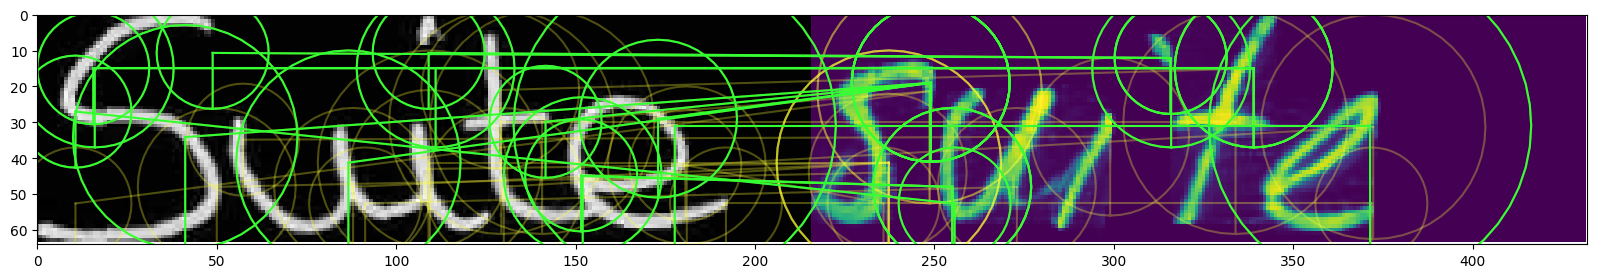

suite


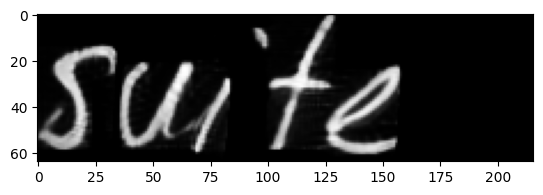

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_1.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_1.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

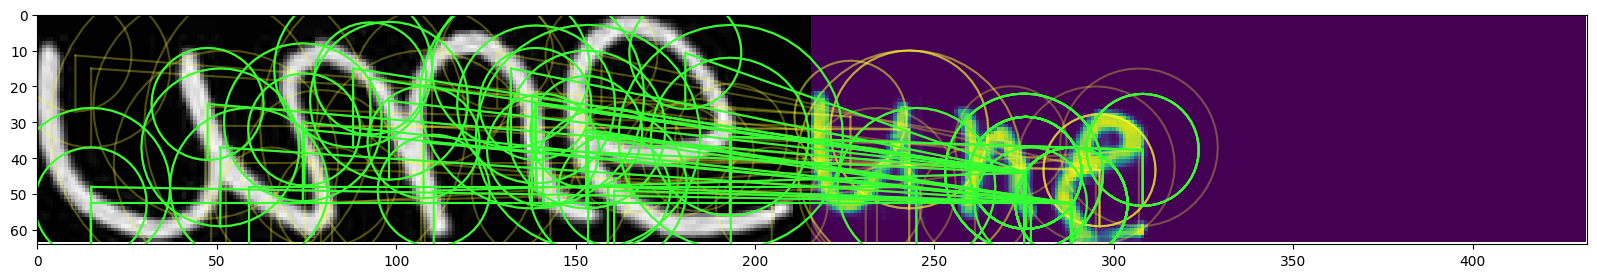

une


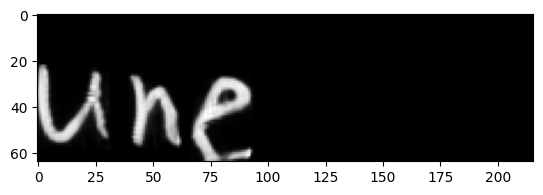

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_3.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_3.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

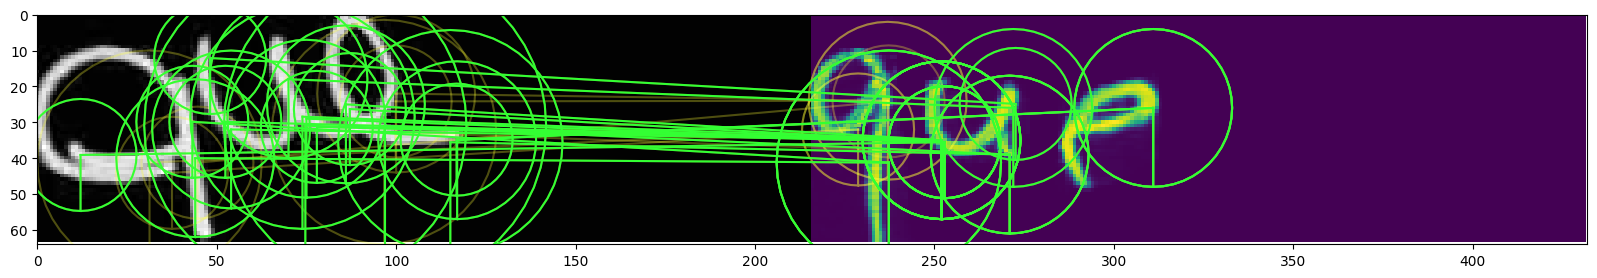

que


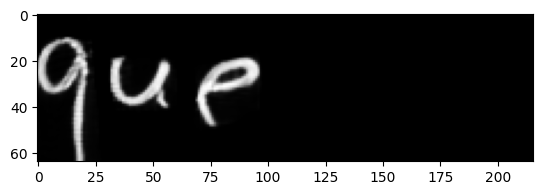

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_4.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_4.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

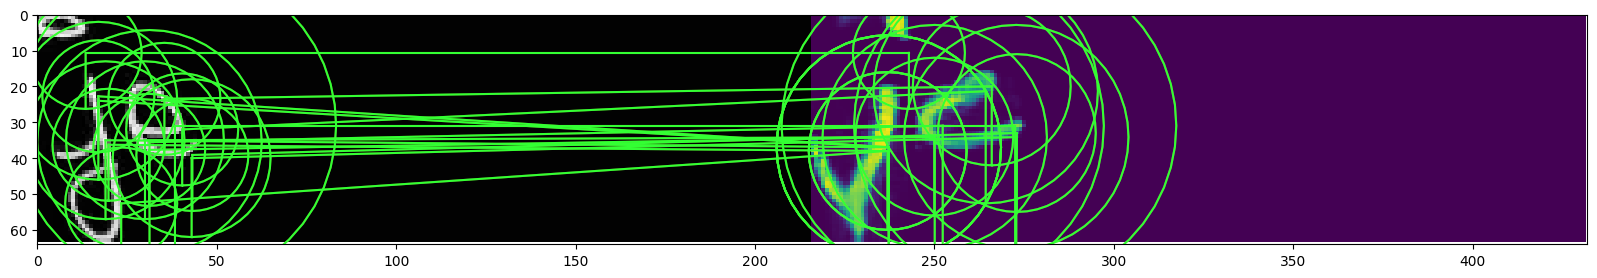

je


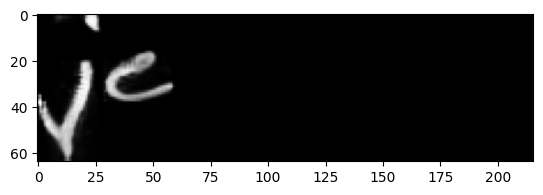

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_5.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_5.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

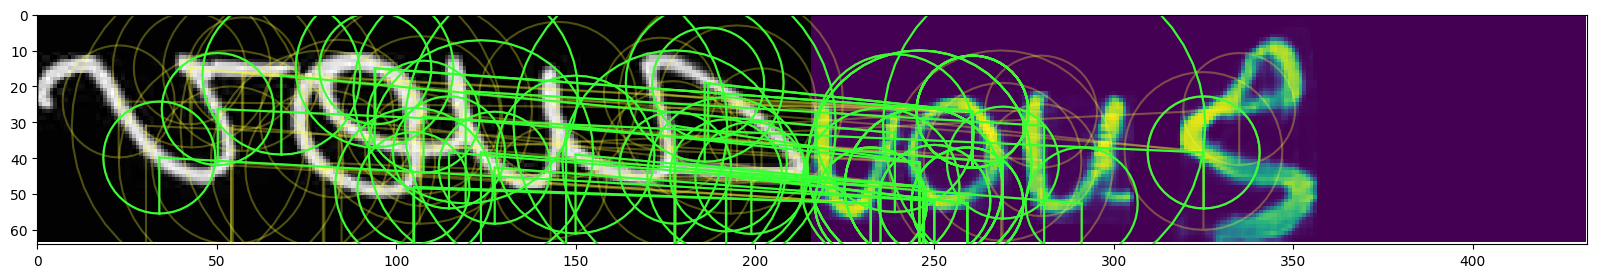

vous


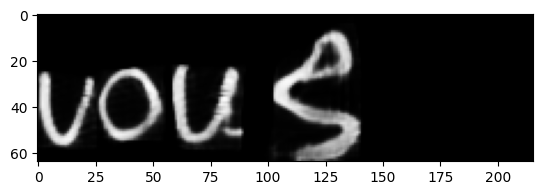

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_6.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_6.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

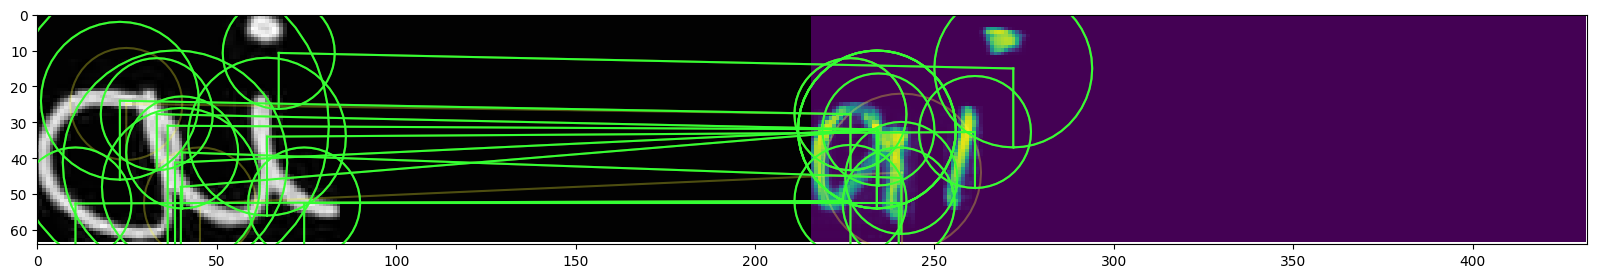

ai


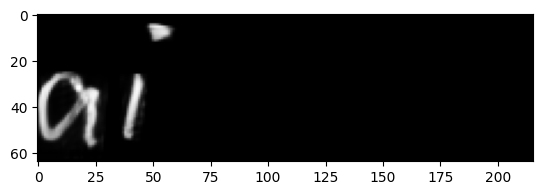

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_0.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_0.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

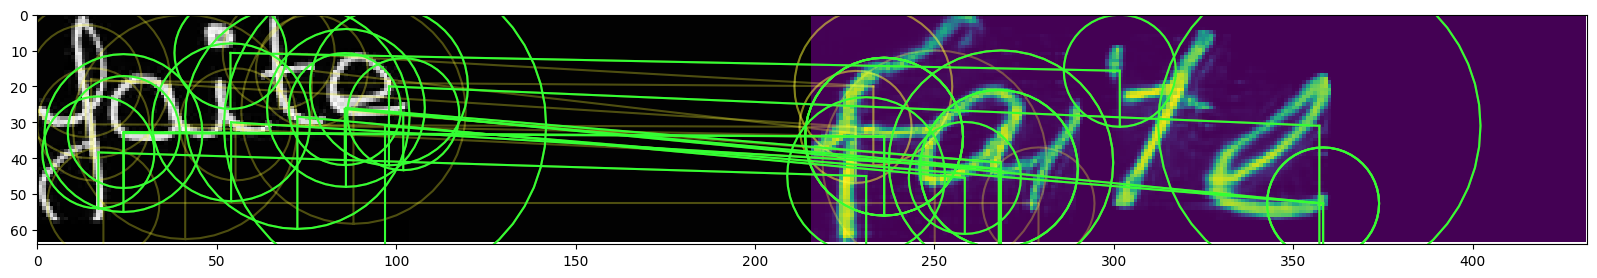

faite


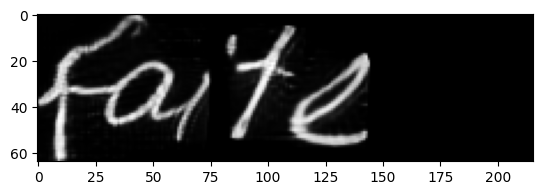

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_1.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_1.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

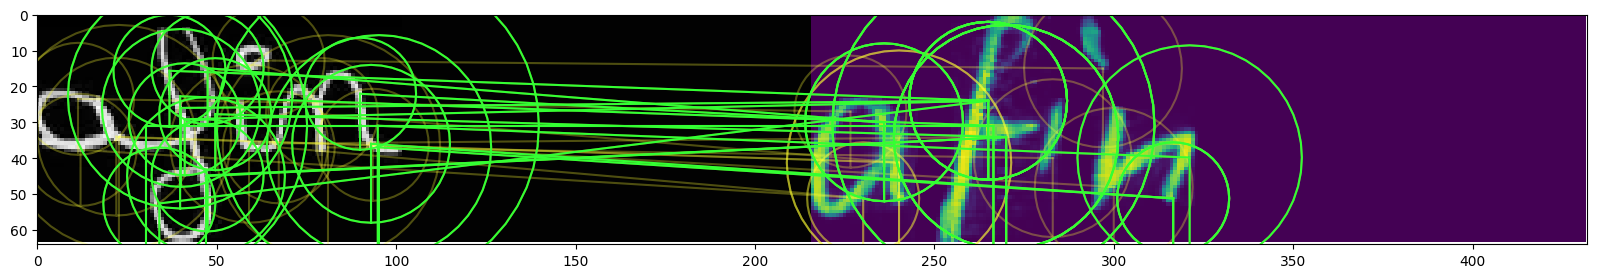

afin


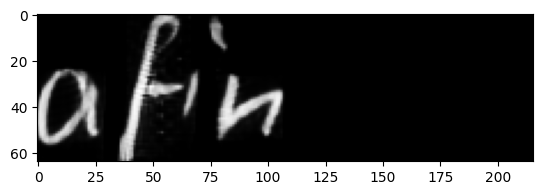

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_3.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_3.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

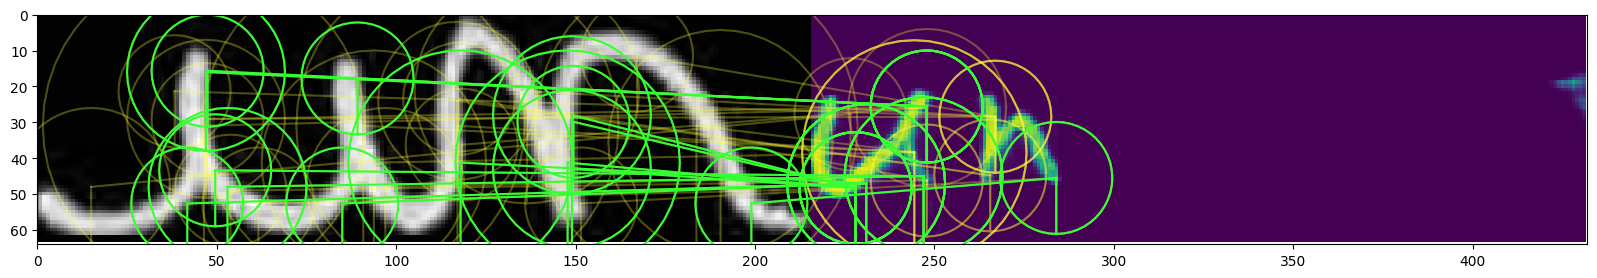

un


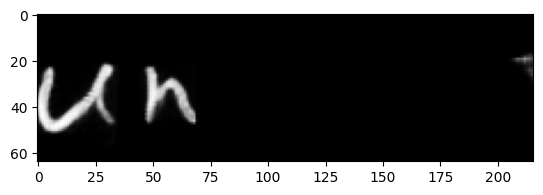

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_5.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_5.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

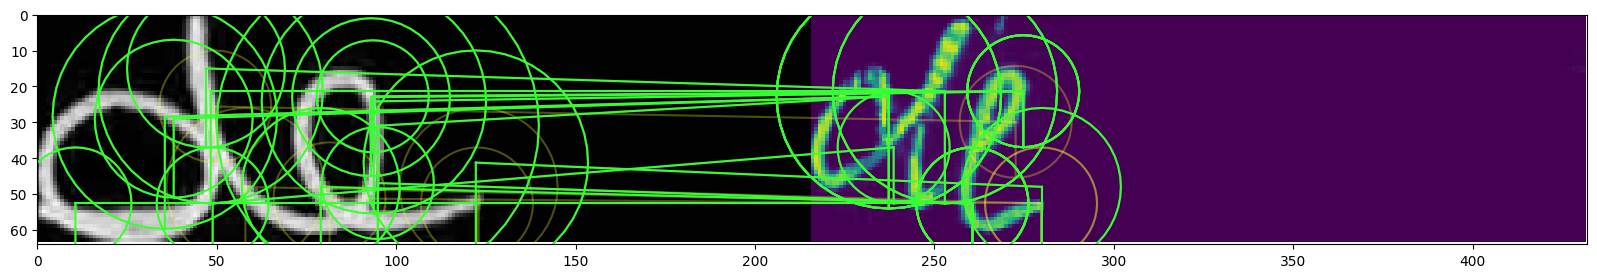

de


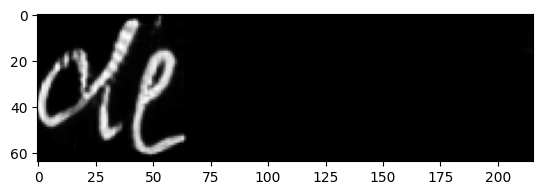

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_2_3.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_2_3.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

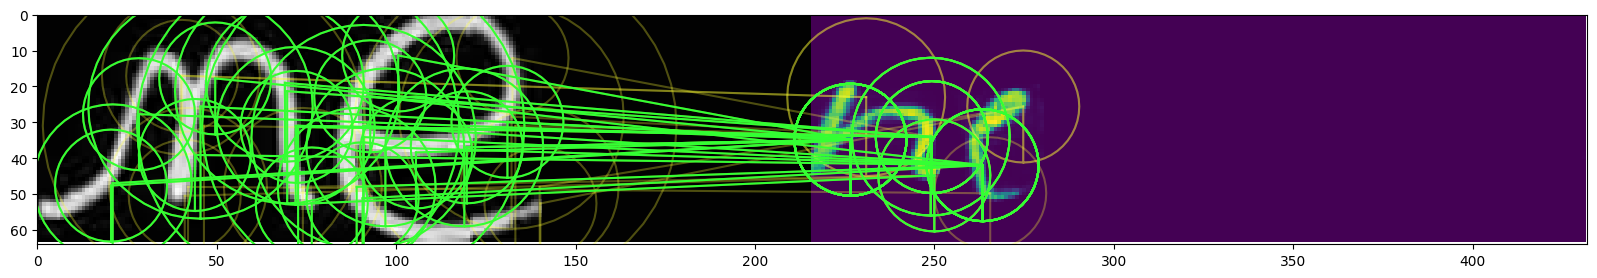

ne


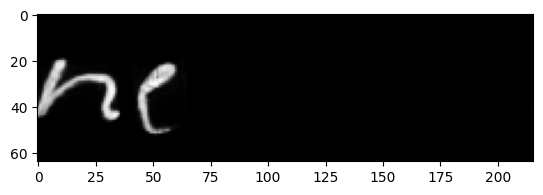

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_4_2.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_4_2.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

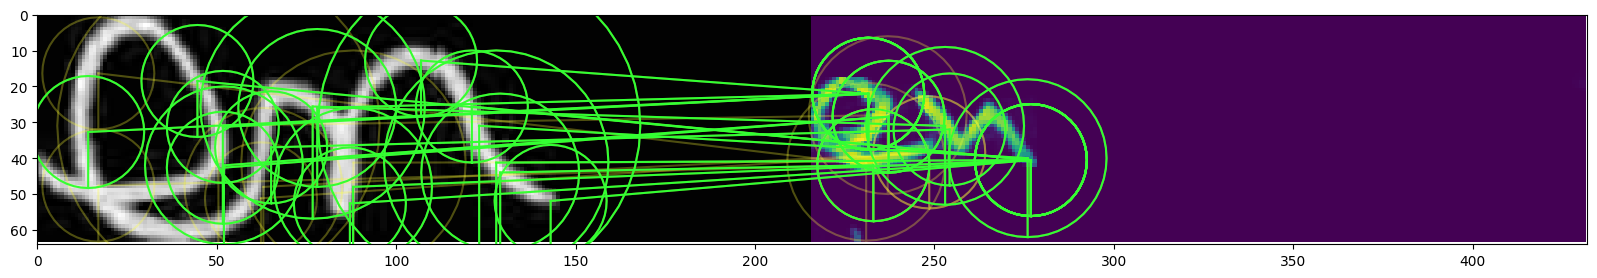

en


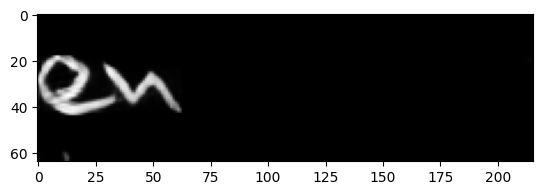

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_4_4.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_4_4.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

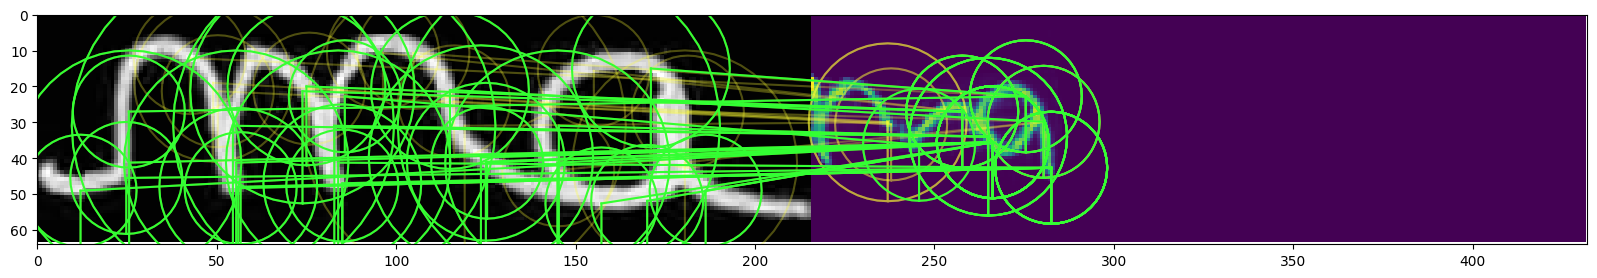

ma


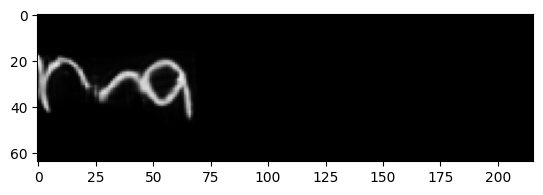

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_5_1.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_5_1.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

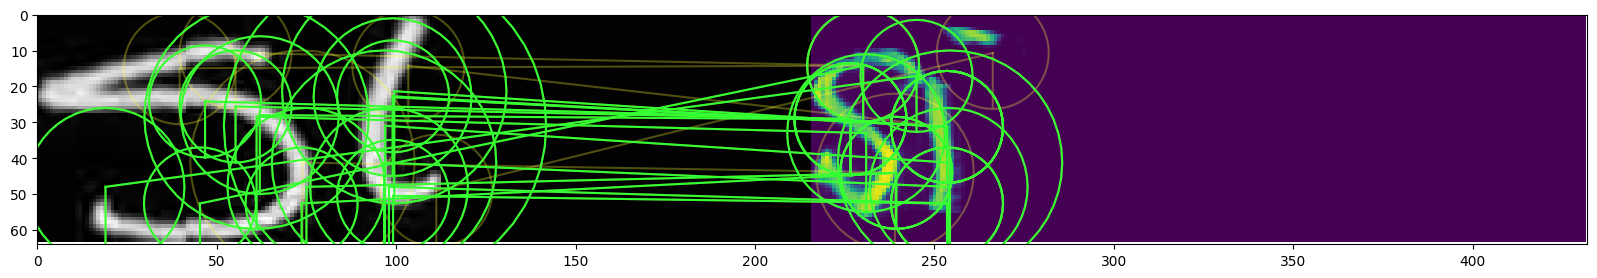

si


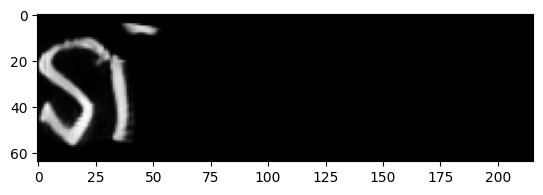

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_5_4.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_5_4.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

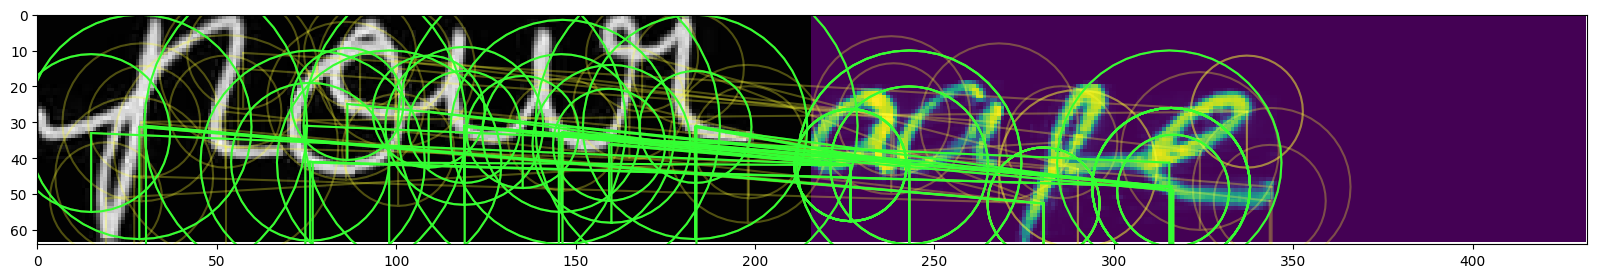

aaxe


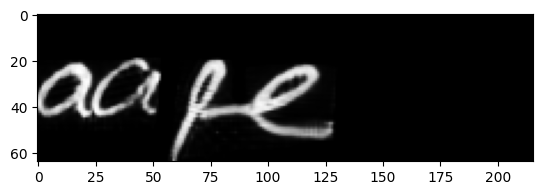

In [124]:
for idx in range(len(img_paths)):
    img_path = "../../" + img_paths[idx]
    img_path = img_path.replace("/", "\\")
    print(img_path, os.getcwd())
    img = 255 - cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    img = transforms_(img)
    print(img.shape)
    gen_input = copy_style_imgs(img, img_path)
    print("copy aug")
    gen_aug_input = copy_style_imgs_aug(img)
    print(gen_aug_input.shape)
    label = tokenizer.encode(labels[idx])
    label = torch.from_numpy(np.array(label)).cuda().long()
    label = torch.nn.functional.one_hot(label, 56).float()
    print(label.shape)

    gen_input = torch.from_numpy(gen_input).squeeze(1).unsqueeze(0).cuda()
    gen_aug_input = torch.from_numpy(gen_aug_input).squeeze(1).unsqueeze(0).cuda()

    synth_img = gen_model(gen_input, label.unsqueeze(0))
    img = img.cuda()
    print(img.shape, synth_img.shape)

    img_stack = torch.stack([img, img, img], dim=1)
    synth_img_stack = torch.stack([synth_img.squeeze(1), synth_img.squeeze(1), synth_img.squeeze(1)], dim=1)

    feature = KF.KeyNetHardNet(5000, True).eval().cuda()

    hw1 = torch.tensor(img.shape[2:])
    hw2 = torch.tensor(synth_img.shape[2:])  

    adalam_config = {"device": torch.device('cuda')}

    with torch.inference_mode():
        lafs1, resps1, descs1 = feature(img.unsqueeze(0))
        lafs2, resps2, descs2 = feature(synth_img)
        dists, idxs = KF.match_adalam(
            descs1.squeeze(0),
            descs2.squeeze(0),
            lafs1,
            lafs2,  # Adalam takes into account also geometric information
            config=adalam_config,
            hw1=hw1,
            hw2=hw2,  # Adalam also benefits from knowing image size
        )

    print(f"{idxs.shape[0]} tentative matches with AdaLAM")

    mkpts1, mkpts2 = get_matching_keypoints(lafs1, lafs2, idxs)

    Fm, inliers = cv2.findFundamentalMat(mkpts1, mkpts2, cv2.USAC_MAGSAC, 0.75, 0.999, 100000)
    inliers = inliers > 0
    print(f"{inliers.sum()} inliers with AdaLAM")

    synth_img = synth_img.detach().cpu()
    img = img.detach().cpu()

    print(mkpts1.shape, mkpts2.shape, torch.mean(dists))

    draw_LAF_matches(
        lafs1.cpu(),
        lafs2.cpu(),
        idxs.cpu(),
        K.tensor_to_image(img),
        K.tensor_to_image(synth_img.squeeze(1)),
        inliers,
        draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
    )


    plt.imshow(img[0], cmap='gray')
    plt.show()
    # plt.imshow(G_y[0], cmap='gray')
    # plt.show()

    print(labels[idx])
    plt.imshow(synth_img[0][0], cmap='gray')
    plt.show()

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_0.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_0.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

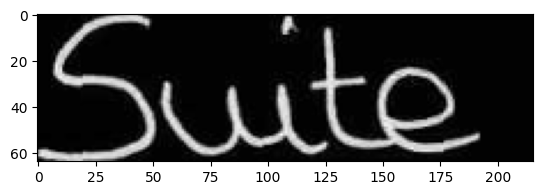

suite


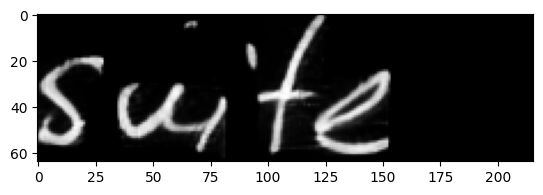

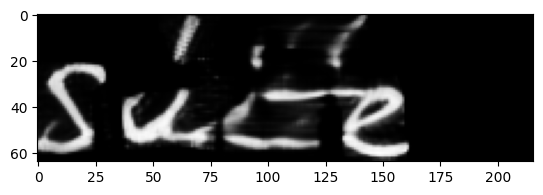

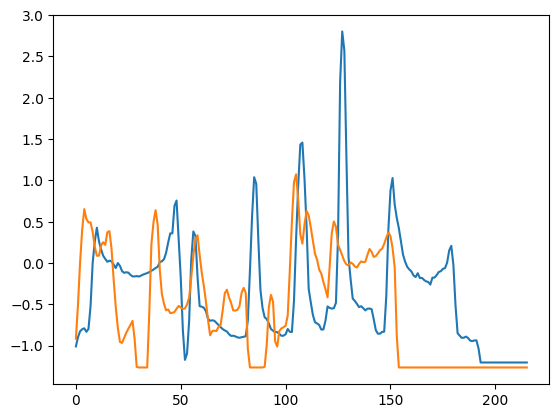

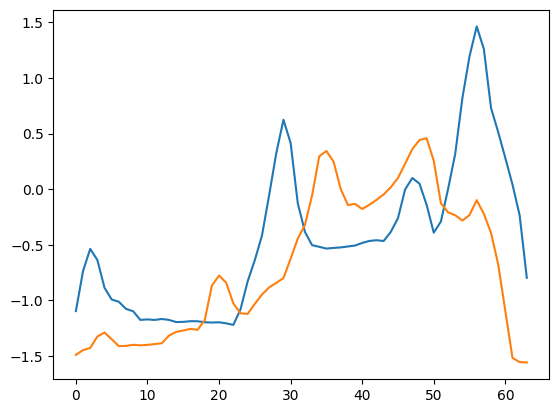

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_1.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_1.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

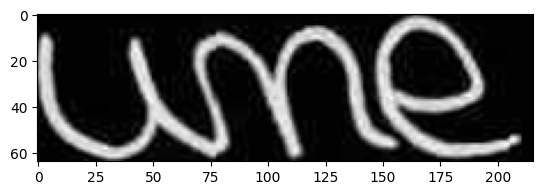

une


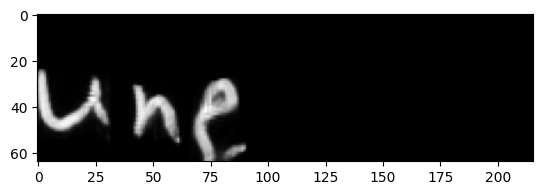

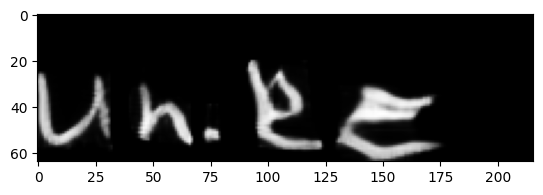

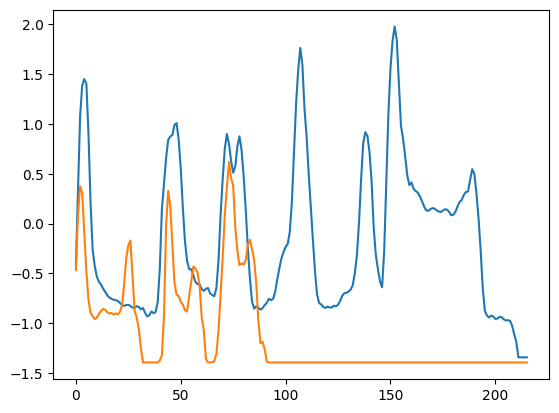

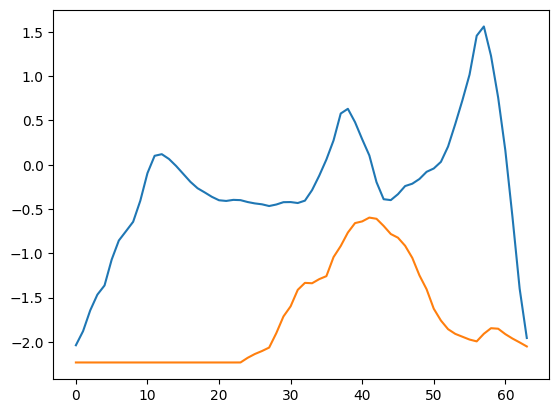

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_3.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_3.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

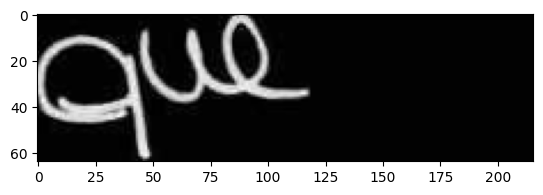

que


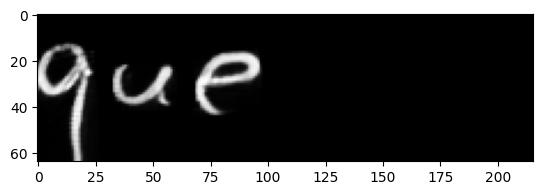

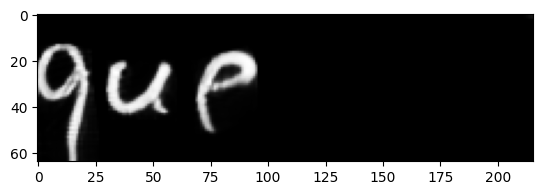

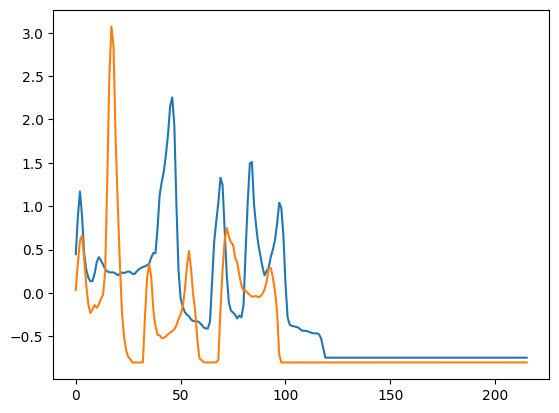

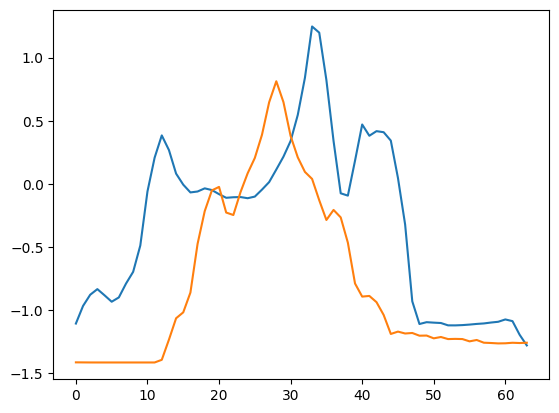

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_4.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_4.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

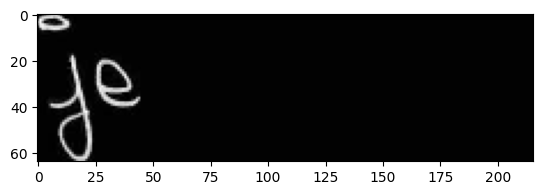

je


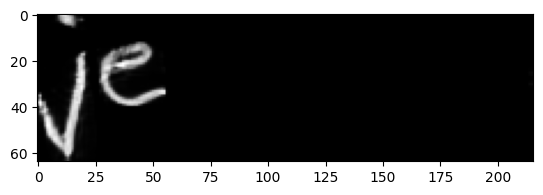

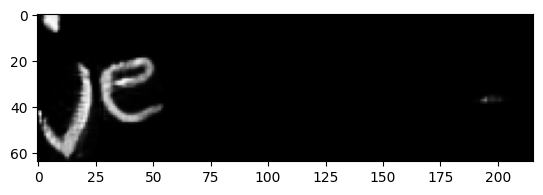

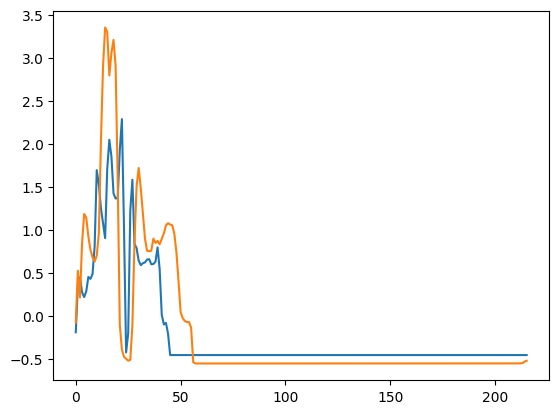

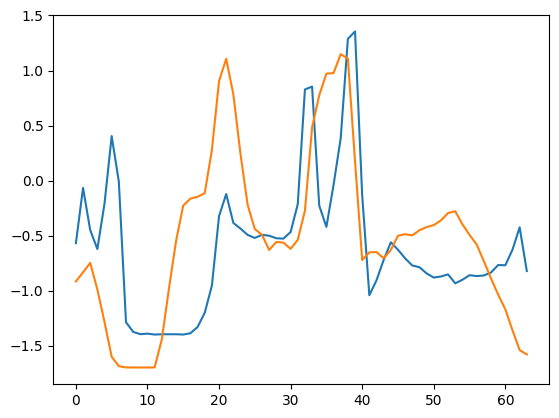

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_5.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_5.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

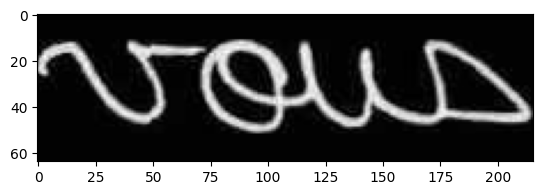

vous


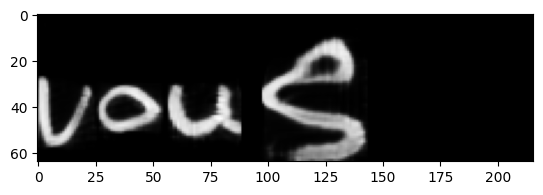

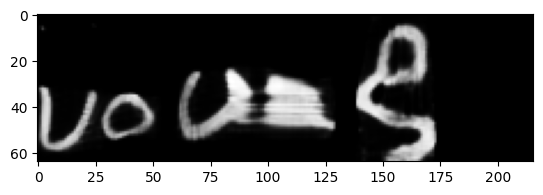

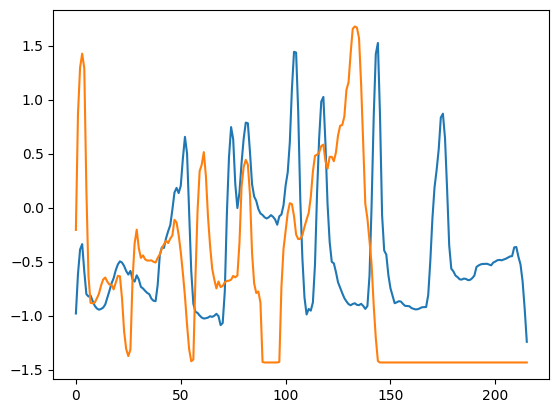

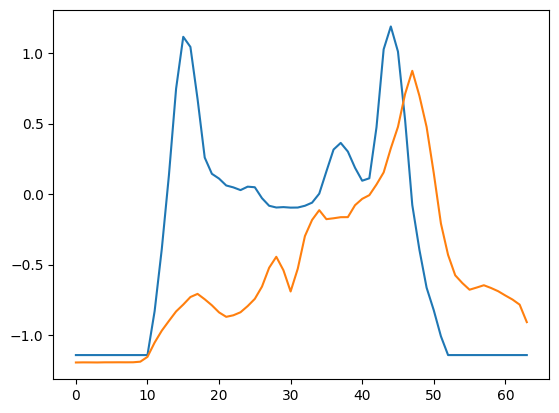

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_6.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_0_6.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

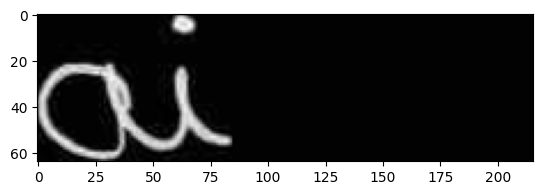

ai


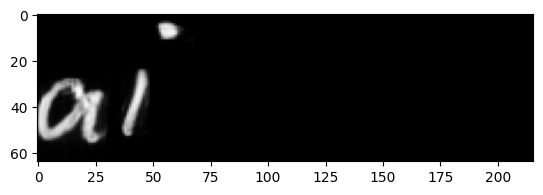

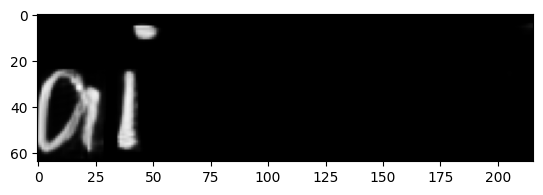

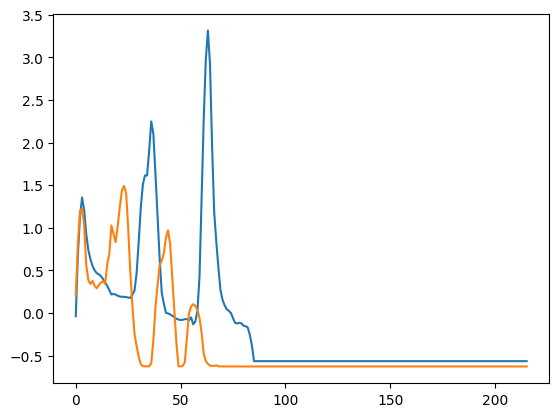

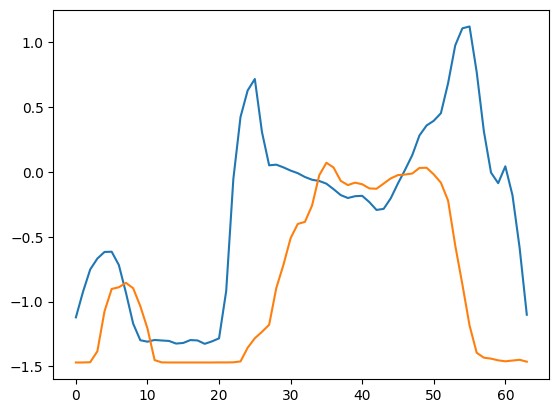

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_0.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_0.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

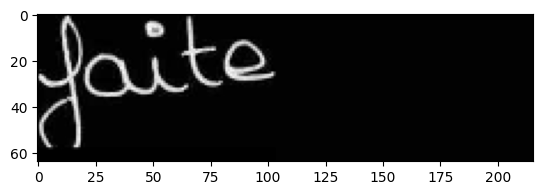

faite


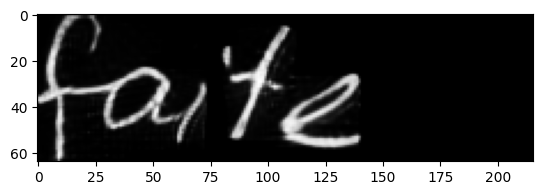

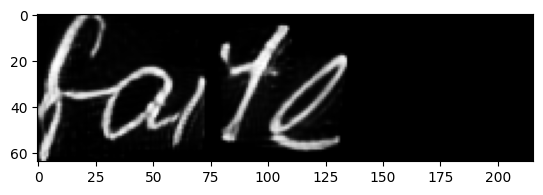

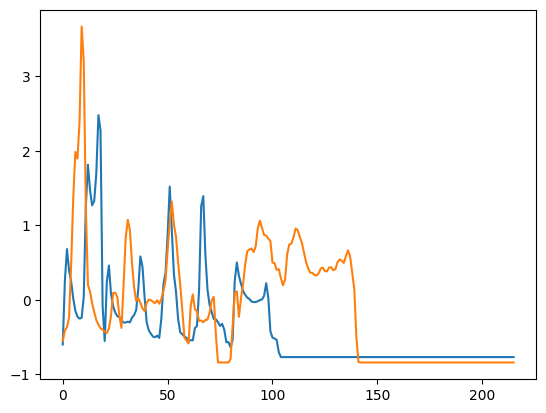

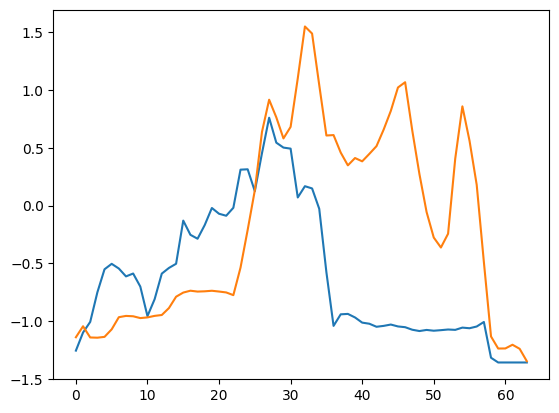

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_1.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_1.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

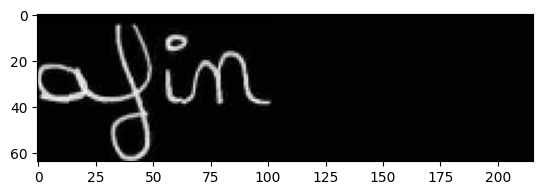

afin


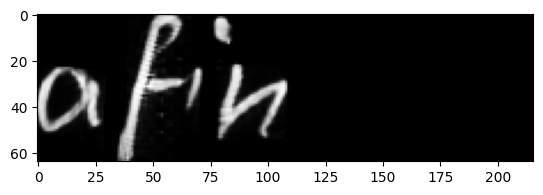

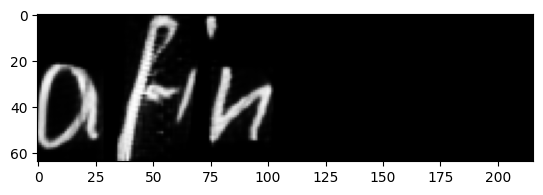

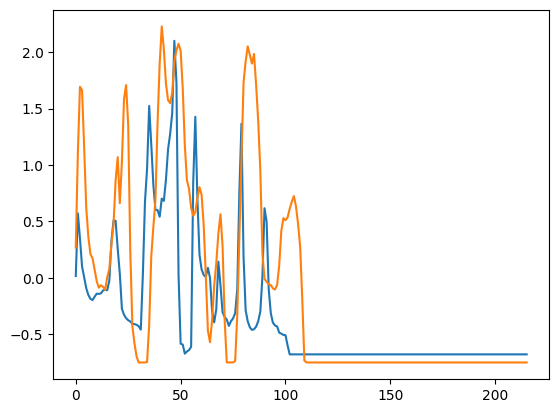

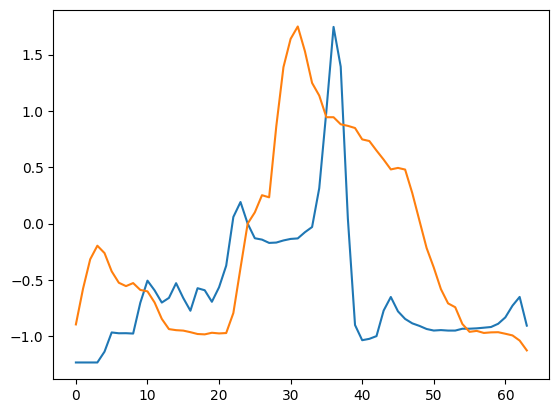

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_3.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_3.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

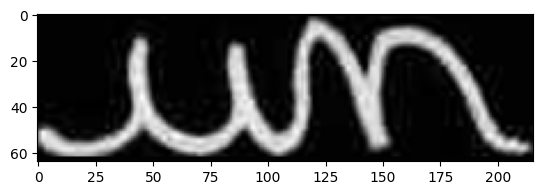

un


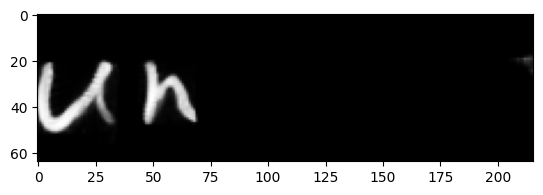

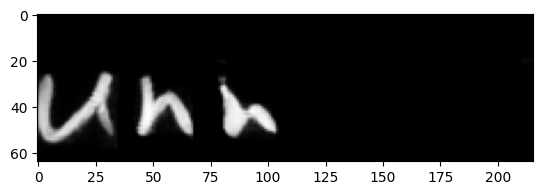

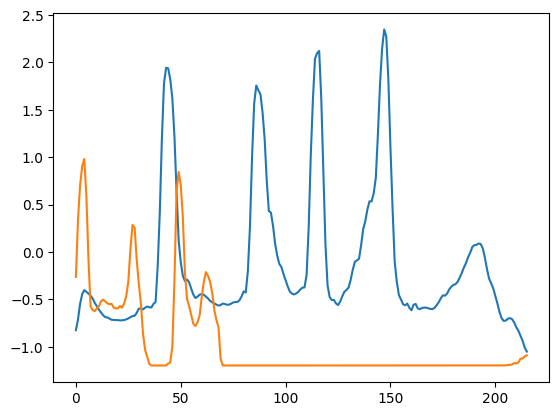

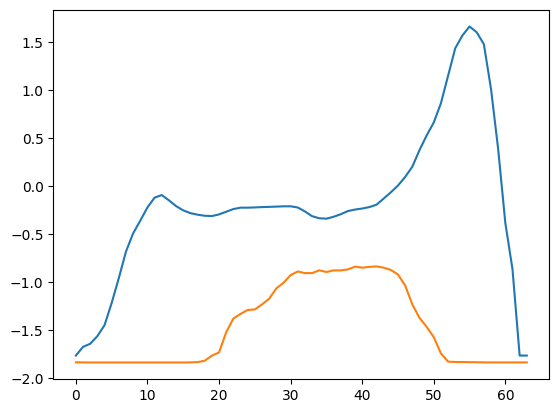

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_5.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_1_5.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

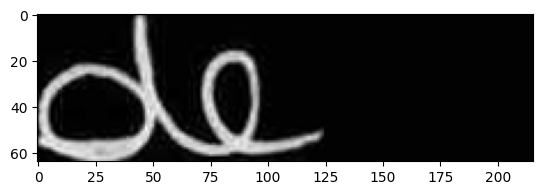

de


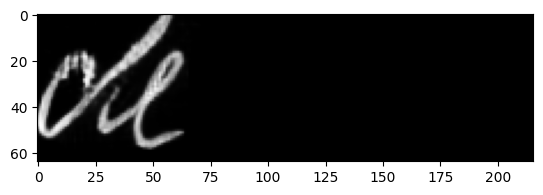

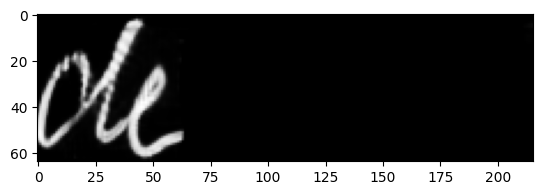

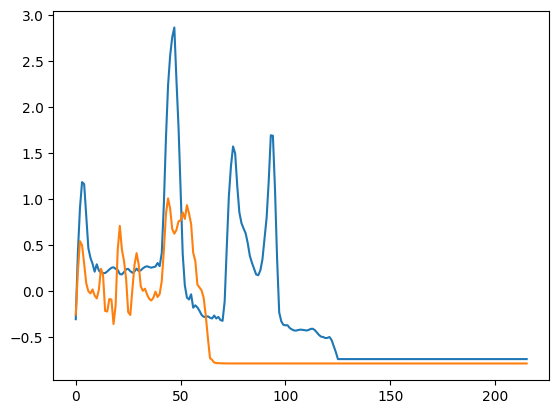

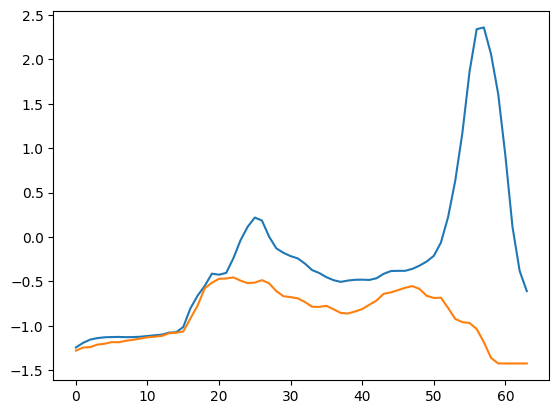

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_2_3.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_2_3.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

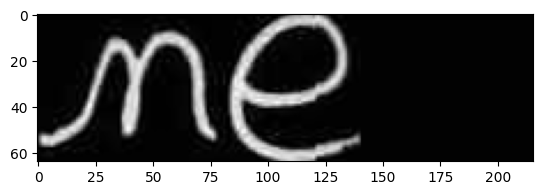

ne


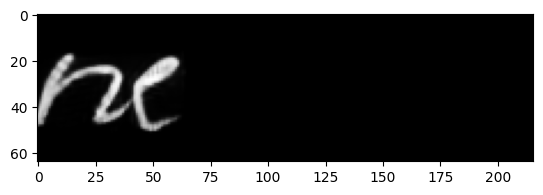

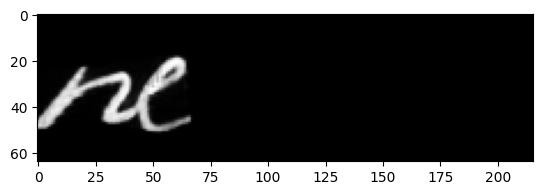

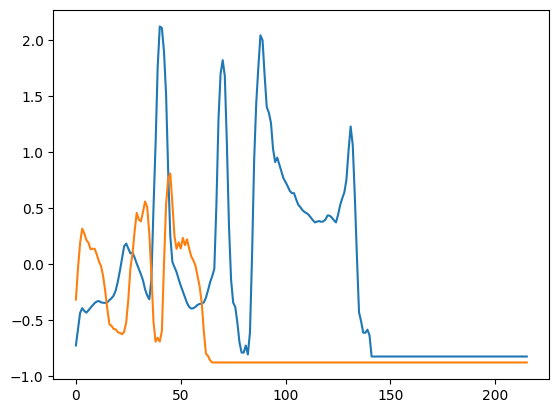

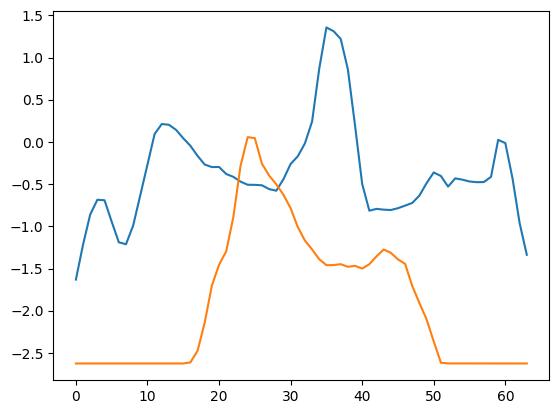

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_4_2.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_4_2.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

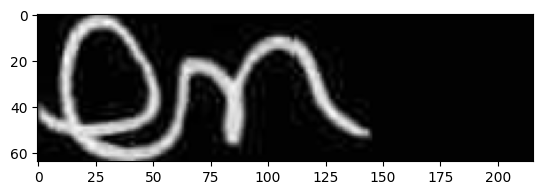

en


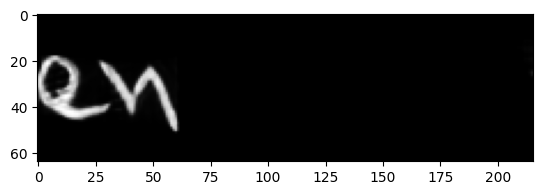

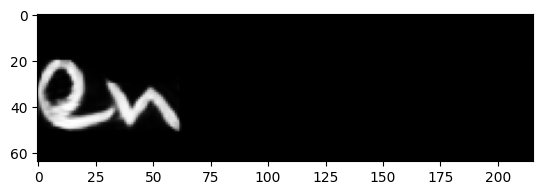

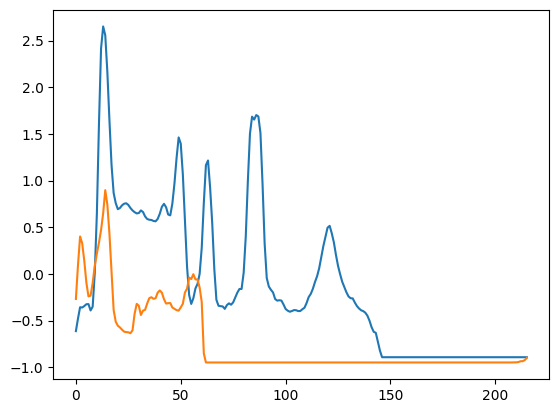

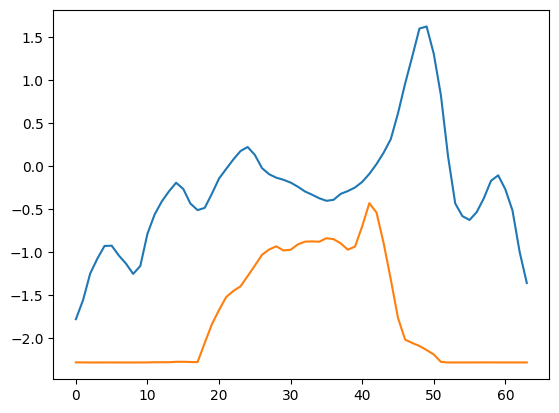

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_4_4.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_4_4.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

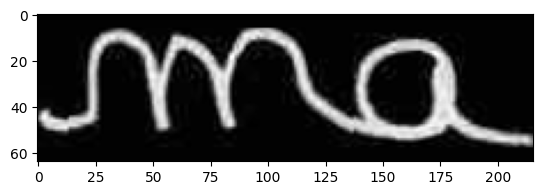

ma


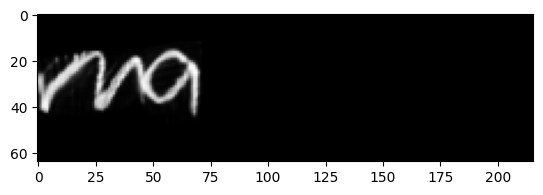

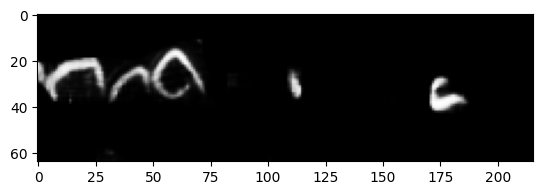

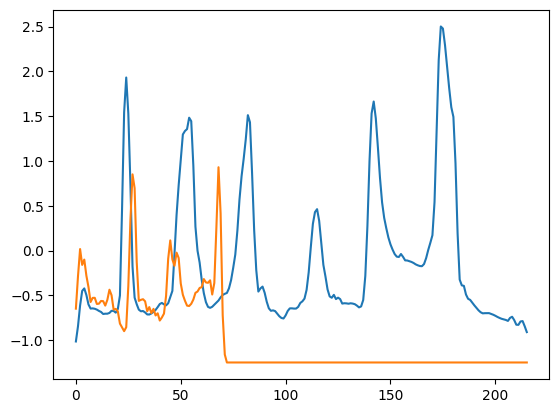

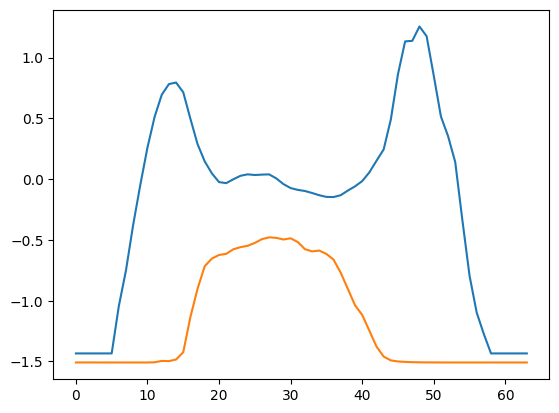

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_5_1.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_5_1.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

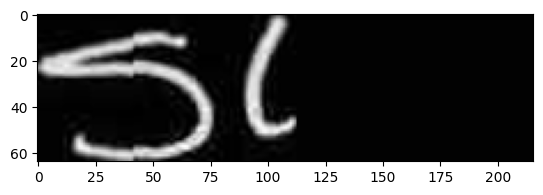

si


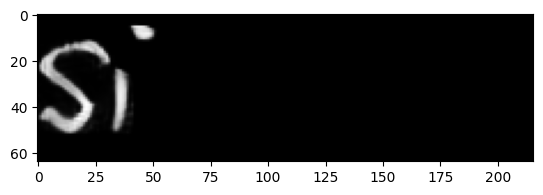

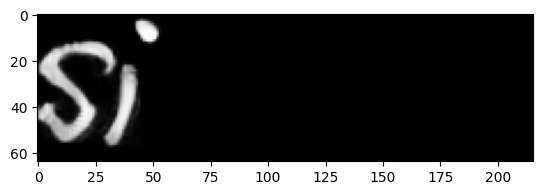

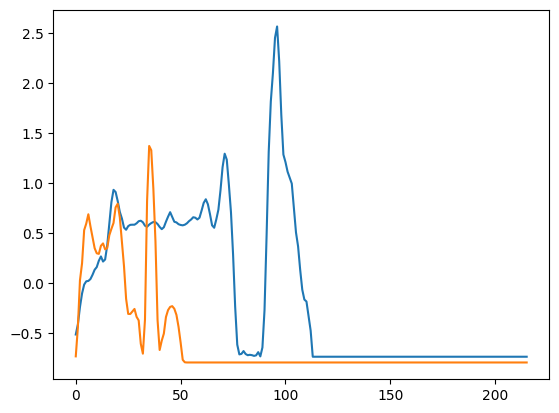

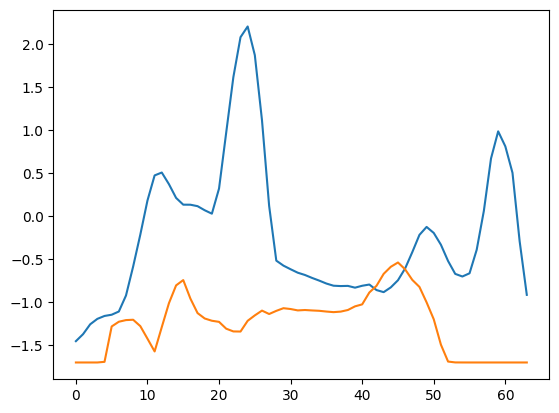

..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_5_4.tiff c:\Users\Lisa\Documents\GitHub\handwriting-recognition\src\network\gen_model
torch.Size([1, 64, 216])
..\..\..\data\rimes\words\valid\lot_16\01550_L\01550_L_5_4.tiff
..\..\..\data\rimes\words\valid\lot_16\01550_L
['..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_2.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_3.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_4.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_5.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_0_6.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_0.tiff', '..\\..\\..\\data\\rimes\\words\\valid\\lot_16\\01550_L\\01550_L_1_1.tiff', '..\\..\\..\\data\\rimes\\words\\valid

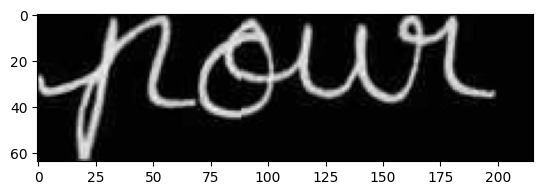

aaxe


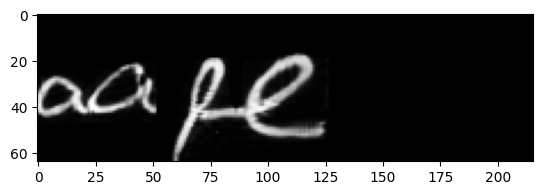

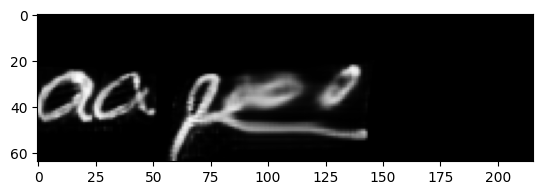

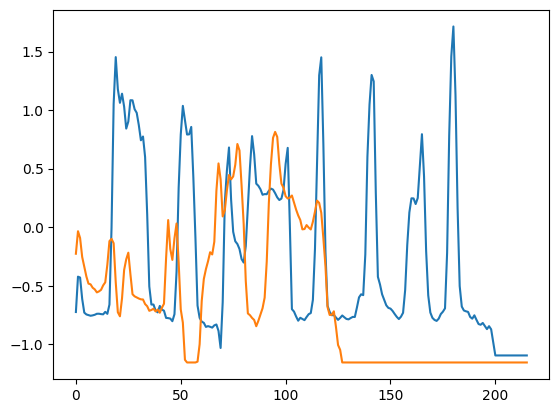

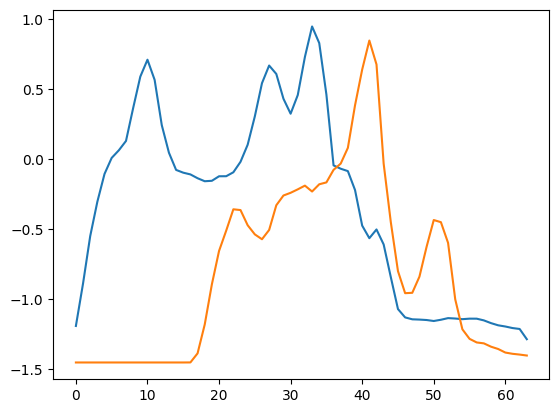

In [125]:
for idx in range(len(img_paths)):
    img_path = "../../" + img_paths[idx]
    img_path = img_path.replace("/", "\\")
    print(img_path, os.getcwd())
    img = 255 - cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    img = transforms_(img)
    print(img.shape)
    gen_input = copy_style_imgs(img, img_path)
    print("copy aug")
    gen_aug_input = copy_style_imgs_aug(img, img_path)
    print(gen_aug_input.shape)
    label = tokenizer.encode(labels[idx])
    label = torch.from_numpy(np.array(label)).cuda().long()
    label = torch.nn.functional.one_hot(label, 56).float()
    print(label.shape)

    gen_input = torch.from_numpy(gen_input).squeeze(1).unsqueeze(0).cuda()
    gen_aug_input = torch.from_numpy(gen_aug_input).squeeze(1).unsqueeze(0).cuda()

    synth_img = gen_model(gen_input, label.unsqueeze(0)).detach().cpu()
    synth_img_aug = gen_model(gen_aug_input, label.unsqueeze(0)).detach().cpu()

    img = img + 1.
    synth_img = synth_img + 1.

    vertical_profile = torch.sum(img, axis=[1]) 
    synth_vertical_profile = torch.sum(synth_img[0], axis=[1]) 
    mean = torch.mean(vertical_profile) + torch.mean(synth_vertical_profile) / 2
    std = torch.std(vertical_profile) + torch.std(synth_vertical_profile) / 2

    vertical_profile = (vertical_profile - mean) / std
    synth_vertical_profile = (synth_vertical_profile - mean) / std    

    horizontal_profile = torch.sum(img, axis=[2]) 
    synth_horizontal_profile = torch.sum(synth_img[0], axis=[2]) 
    
    mean = torch.mean(horizontal_profile) + torch.mean(synth_horizontal_profile) / 2
    std = torch.std(horizontal_profile) + torch.std(synth_horizontal_profile) / 2

    horizontal_profile = (horizontal_profile - mean) / std
    synth_horizontal_profile = (synth_horizontal_profile - mean) / std    
    
    print(synth_vertical_profile.shape, synth_img.shape)

    vertical_filter = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
    conv1 =torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    conv1.weight = torch.nn.Parameter(torch.from_numpy(vertical_filter).float().unsqueeze(0).unsqueeze(0))
    G_y = conv1(img).data.view(1,img.shape[1], img.shape[2])
    G_y = (G_y - torch.min(G_y)) / (torch.max(G_y) - torch.min(G_y))
    print(torch.min(G_y))
    G_y = (G_y >= 0.7) +  (G_y <= 0.3)

    plt.imshow(img[0], cmap='gray')
    plt.show()
    # plt.imshow(G_y[0], cmap='gray')
    # plt.show()

    print(labels[idx])
    plt.imshow(synth_img[0][0], cmap='gray')
    plt.show()
    plt.imshow(synth_img_aug[0][0], cmap='gray')
    plt.show()


    plt.plot([i for i in range(216)], vertical_profile[0])
    plt.plot([i for i in range(216)], synth_vertical_profile[0])
    plt.show()

    plt.plot([i for i in range(64)], horizontal_profile[0])
    plt.plot([i for i in range(64)], synth_horizontal_profile[0])
    plt.show()

    


In [126]:
beam_search_decoder = ctc_decoder(
    tokens=[char for char in tokenizer.chars],
    nbest=3,
    beam_size=1500
)

NameError: name 'ctc_decoder' is not defined